# Automated Sentiment Analysis for Movie Reviews

## Introduction:

The Film Junky Union, an innovative and edgy community for classic movie enthusiasts, is embarking on an exciting project to enhance the way movie reviews are filtered and categorized. This initiative aims to develop a sophisticated system capable of automatically detecting negative reviews with high accuracy. Leveraging a dataset of IMDb movie reviews, which includes polarity labeling, the goal is to train a robust model that can effectively classify reviews as positive or negative. Achieving an F1 score of at least 0.85 is crucial to ensure the reliability and precision of the system. This project not only promises to streamline the review process but also enriches the user experience by providing more relevant and insightful feedback on classic movies.

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import string
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import sklearn.metrics as metrics
import torch
import transformers
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from nltk.corpus import stopwords
import spacy
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8-darkgrid')

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [3]:
df_reviews = pd.read_csv('/Users/keithrobinson/Desktop/TripleTen/Projects/project14/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [4]:
df_reviews.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info() # look at end year, runtime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.isnull().sum() # check for nulls

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [8]:
df_reviews[df_reviews['average_rating'].isnull()] # checking out the nulls

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


There's only 2 and we have quit a bit of missing information, so I'm going to drop these rows.

In [9]:
df_reviews.dropna(subset=['average_rating'], inplace=True) # drop the nulls
df_reviews['average_rating'].isnull().sum() # check for nulls again

np.int64(0)

In [10]:
df_reviews.duplicated().sum() # check for duplicates

np.int64(0)

## EDA

Let's check the number of movies and reviews over years.

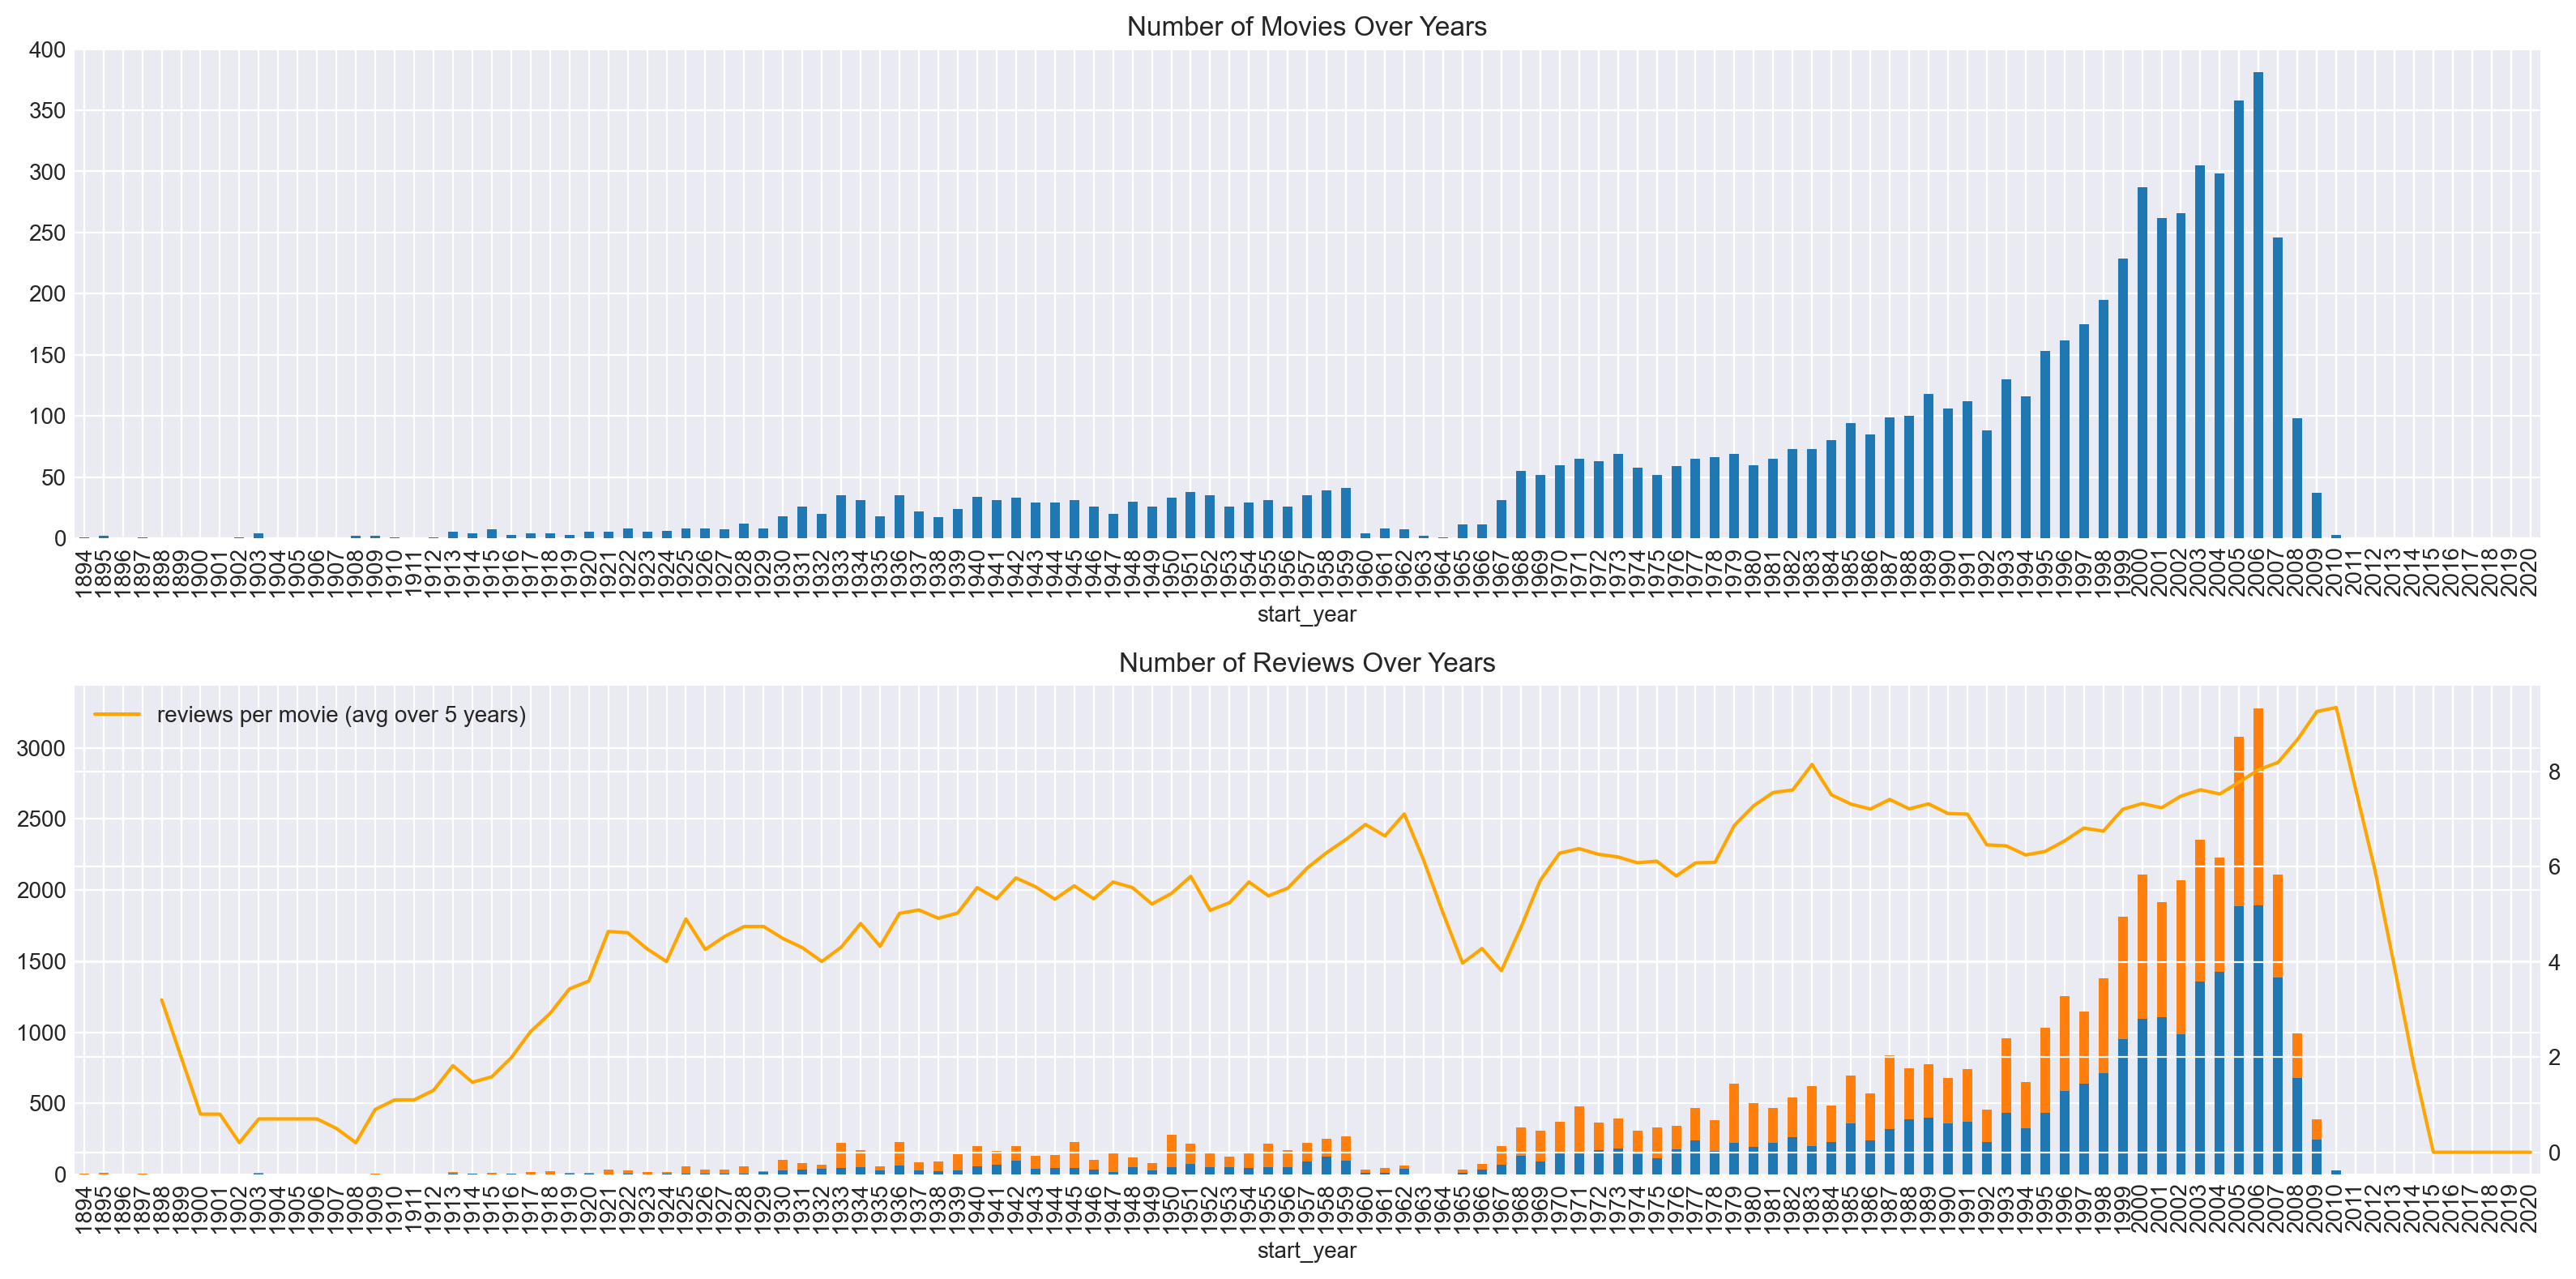

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Before 1968, fewer than 50 movies were released annually. From that point, the number of movies released each year steadily increased, peaking at 381 in 2006. However, by 2010, the number of yearly releases had dropped to nearly zero.

The average number of reviews per movie shows a hysteresis effect due to the rolling calculation method. Generally, it mirrors the trend of increasing movie releases until 2006, though the rate of increase is less steep. Despite the low number of movies released before 1960, the number of reviews remained substantial. Interestingly, there is a peak in the average number of reviews in 1894, indicating that people enjoy reviewing the oldest movies.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

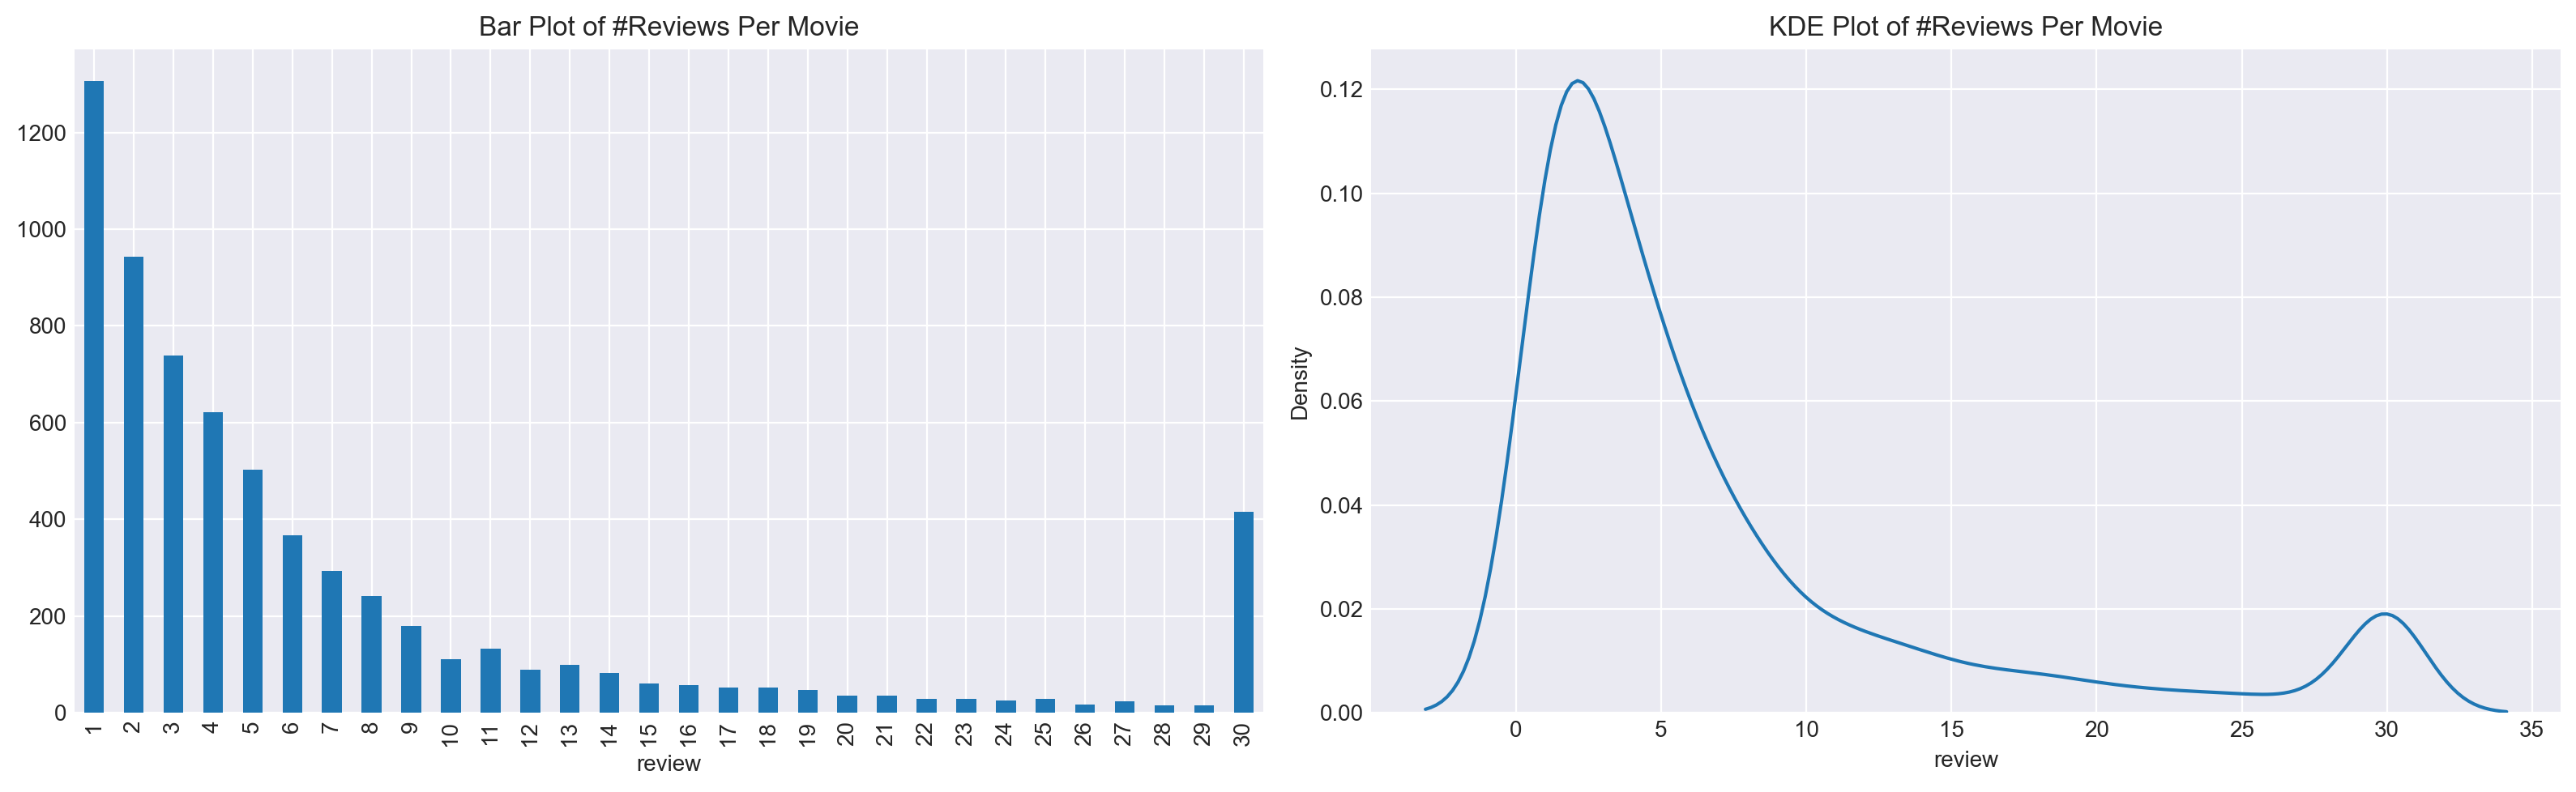

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Most of movies have less than 5 reviews, then the number of reviews decreases gradually until about 29 reviews. Lastly, we see a peak that more than 400 movies have 30 reviews.

In [13]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

Distribution of negative and positive reviews over the years for two parts of the dataset

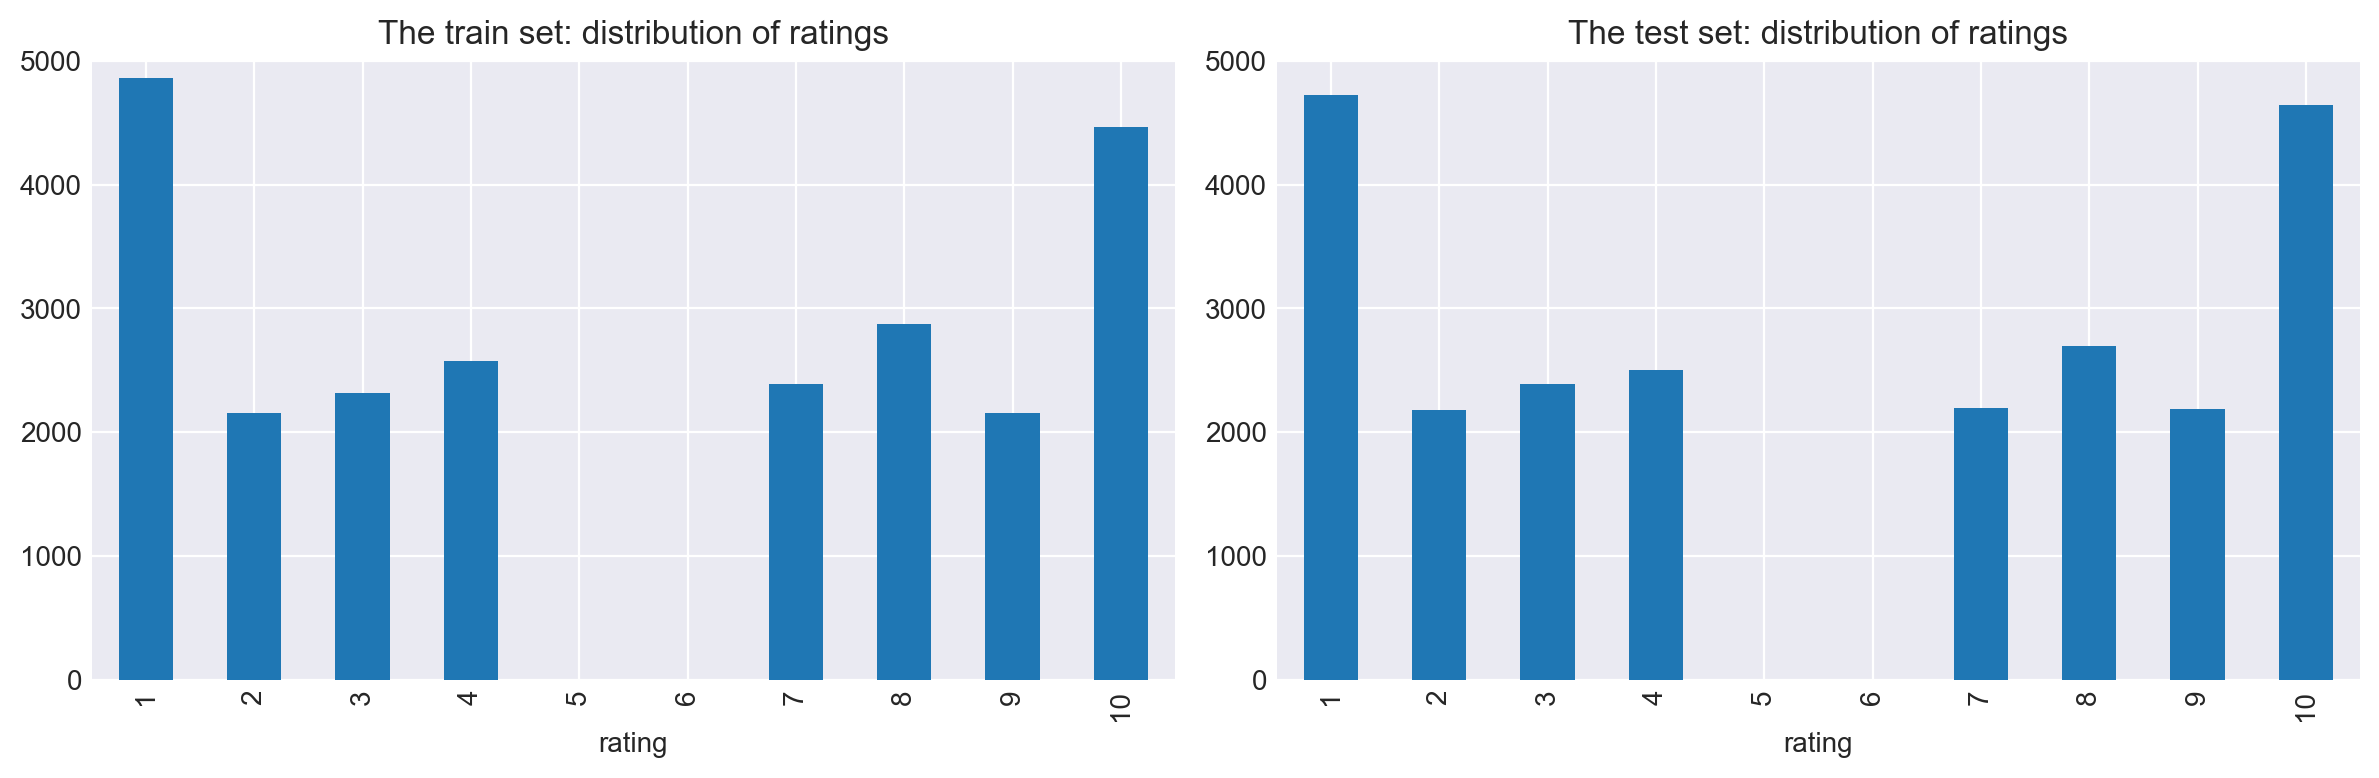

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution of ratings from training and testing set are the same.

The ratings shows polarization. There is no ratings in the middle score, while the scores of 1 and 10 take significant proportion

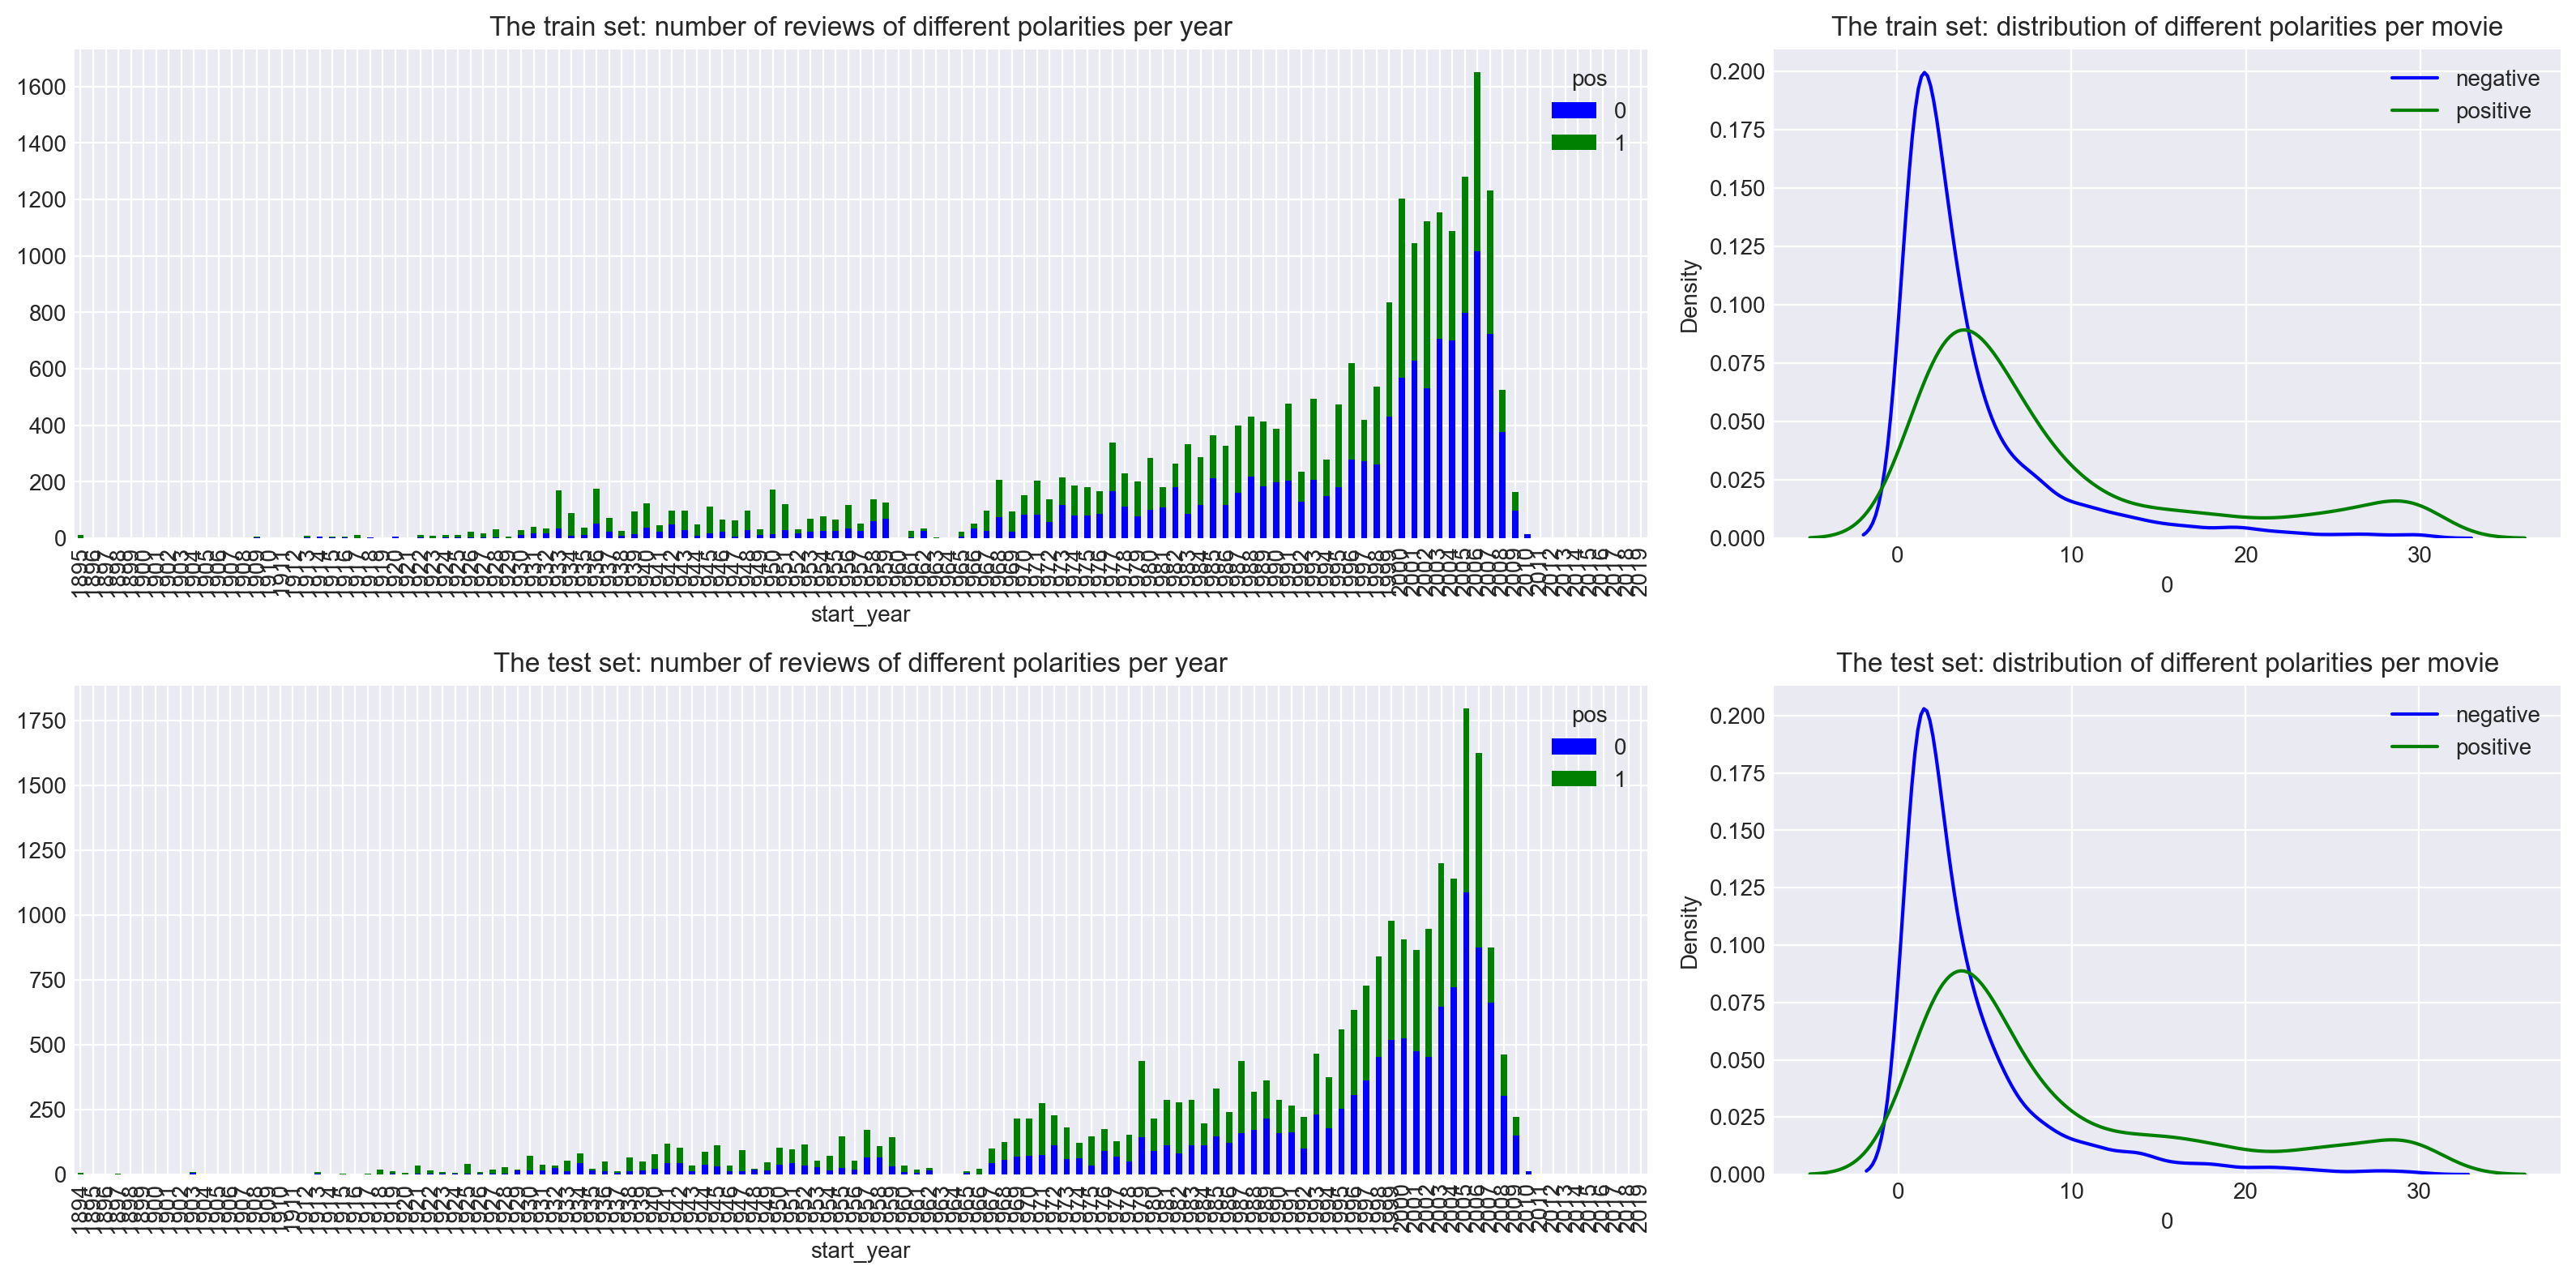

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax, color=['blue', 'green'])  
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax, color=['blue', 'green'])
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

There is an interesting point that the movies with fewer reviews generally have negative ratings, on the other hand, movies with more than 5 reviews have more positive comments than negative ones. Especially for movies with more than 20 reviews, there is quite few negative reviews.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [17]:
def normalize(text):
    text = text.lower()
    text = re.sub(r'[{}]'.format(string.punctuation + string.digits), ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [18]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize)

In [19]:
df_reviews['review_norm'].head(10)

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
5    this is the first movie i ve seen from singapo...
6    yes non singaporean s can t see what s the big...
7    this true story of carlson s raiders is more o...
8    should have been titled balderdash little in t...
9    the movie gung ho the story of carlson s makin...
Name: review_norm, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']
train_features = df_reviews_train.drop(['pos', 'ds_part'], axis=1)
test_features = df_reviews_test.drop(['pos', 'ds_part'], axis=1)
print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


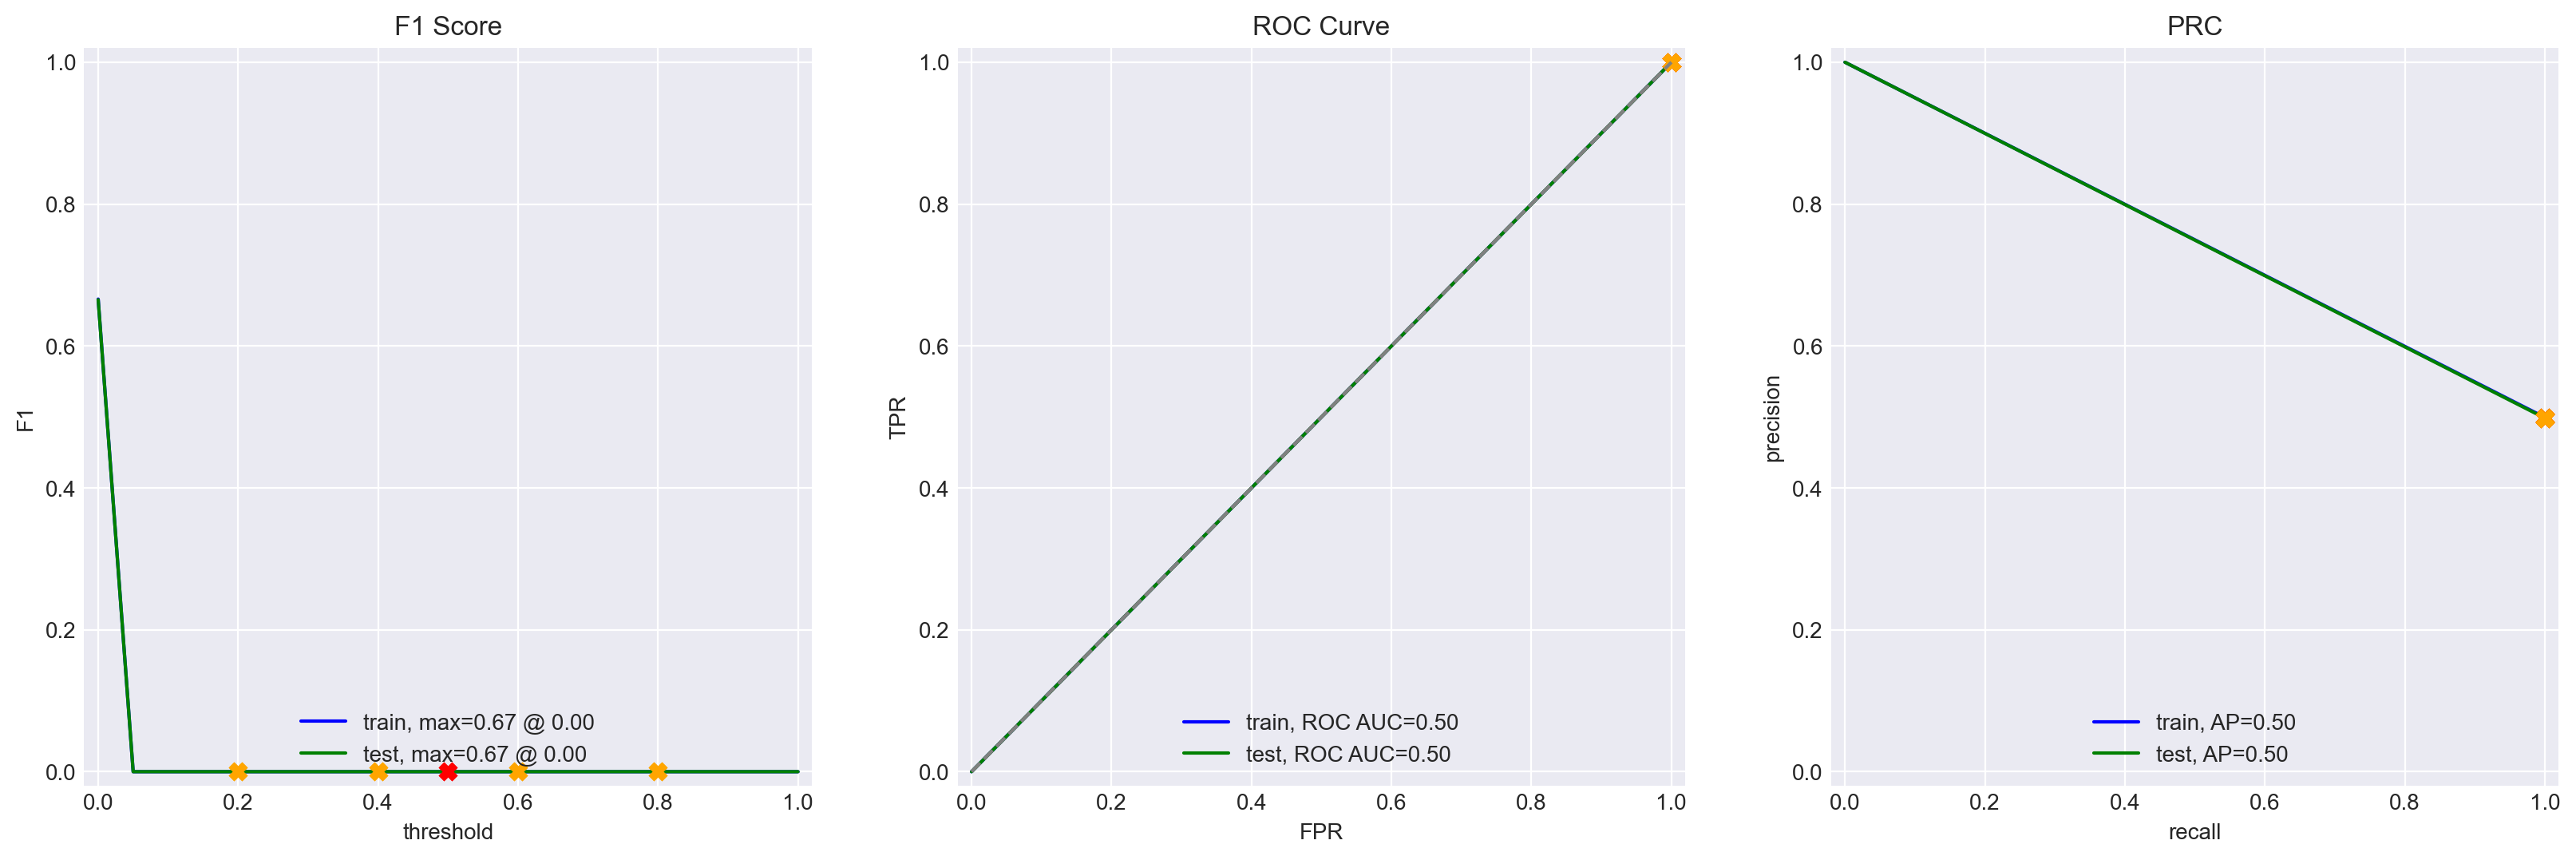

In [21]:
model_0 = DummyClassifier(strategy='most_frequent', random_state=42)
model_0.fit(train_features, train_target)
evaluate_model(model_0, train_features, train_target, test_features, test_target)

### Model 1 - NLTK, TF-IDF and LR

In [22]:
stop_words = set(stopwords.words('english'))
count_tf_idf_1 = TfidfVectorizer(stop_words='english', max_features=1000)

train_corpus_1 = train_features['review_norm']
train_features_1 = count_tf_idf_1.fit_transform(train_corpus_1)
test_corpus_1 = test_features['review_norm']
test_features_1 = count_tf_idf_1.transform(test_corpus_1)

model_1 = LogisticRegression(random_state=42, max_iter=1000)
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.94  0.93
ROC AUC    0.94  0.93


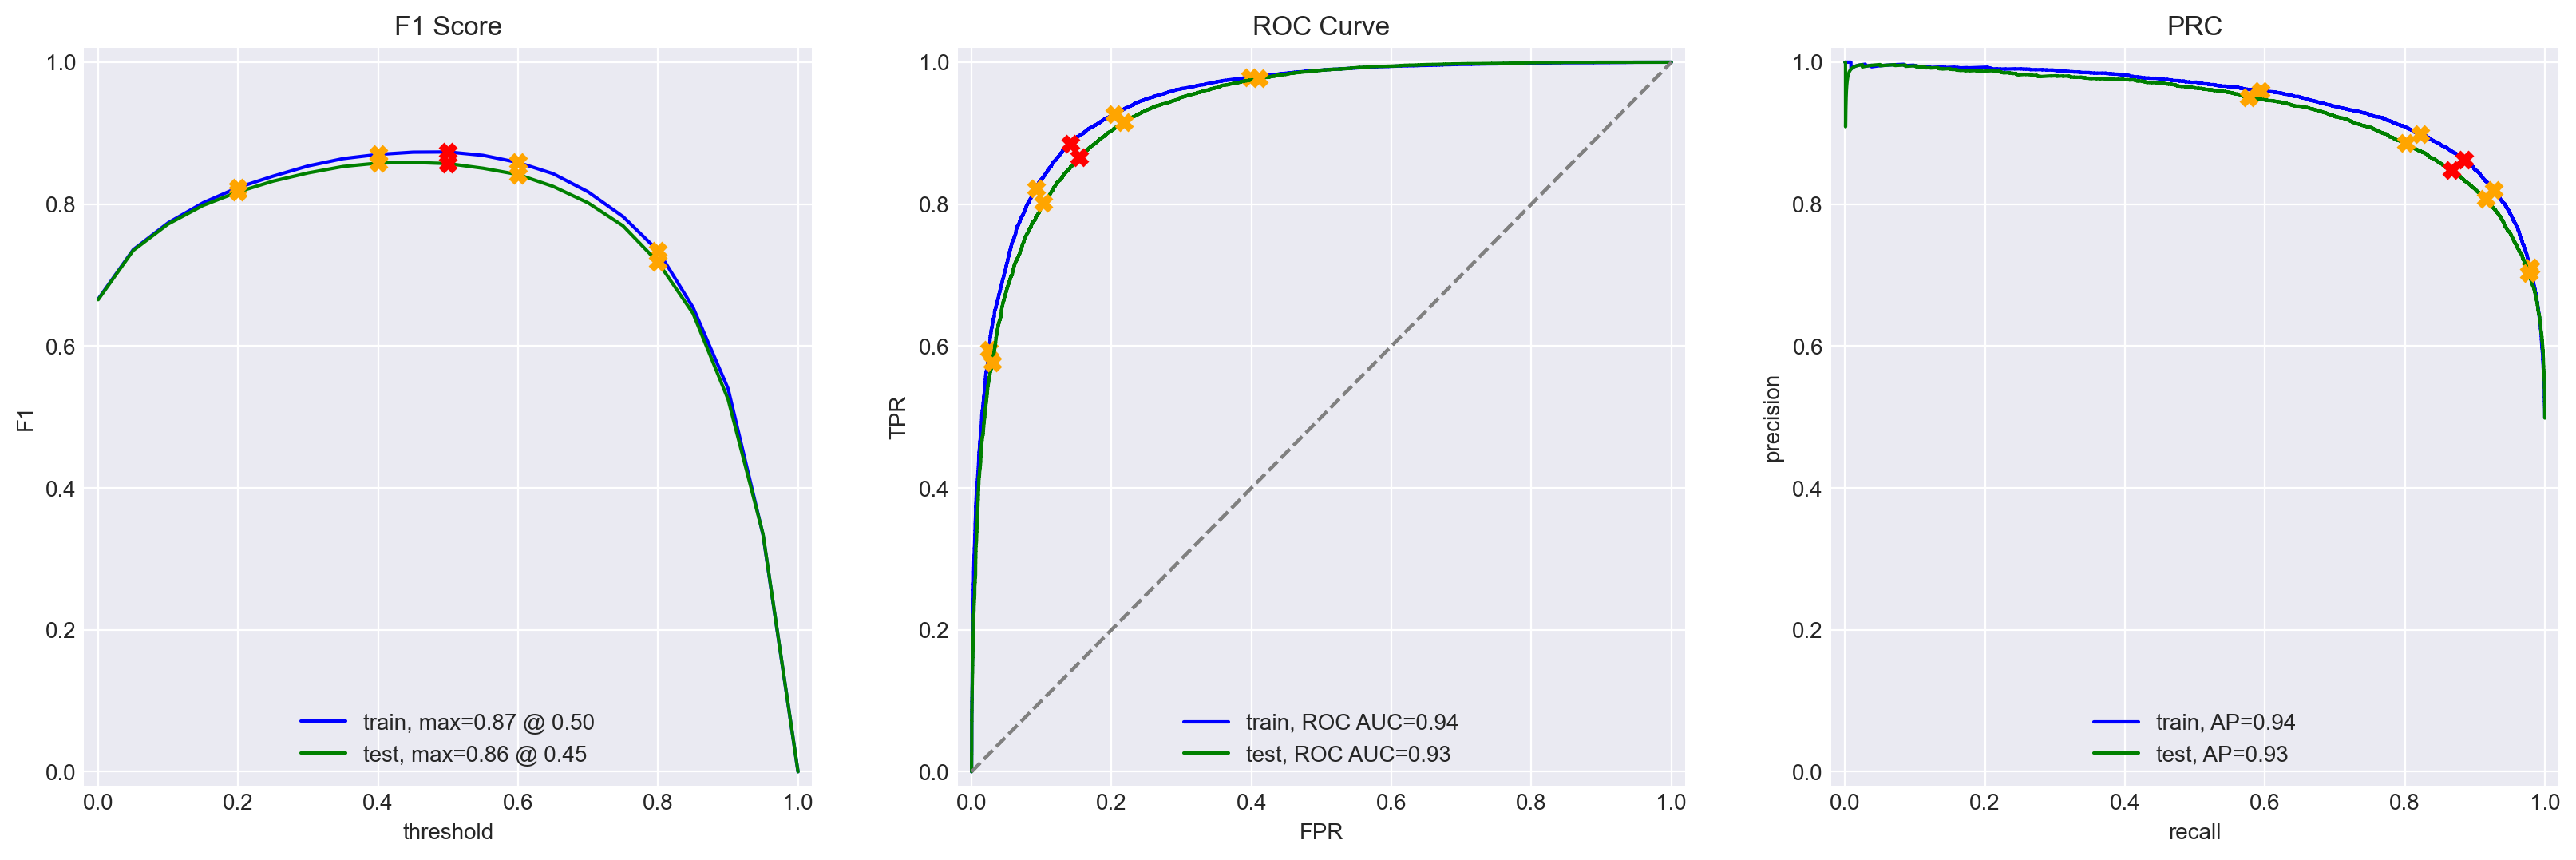

In [23]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 - NLTK, TF-IDF and XGBoost

          train  test
Accuracy   0.94  0.84
F1         0.94  0.84
APS        0.99  0.91
ROC AUC    0.99  0.92


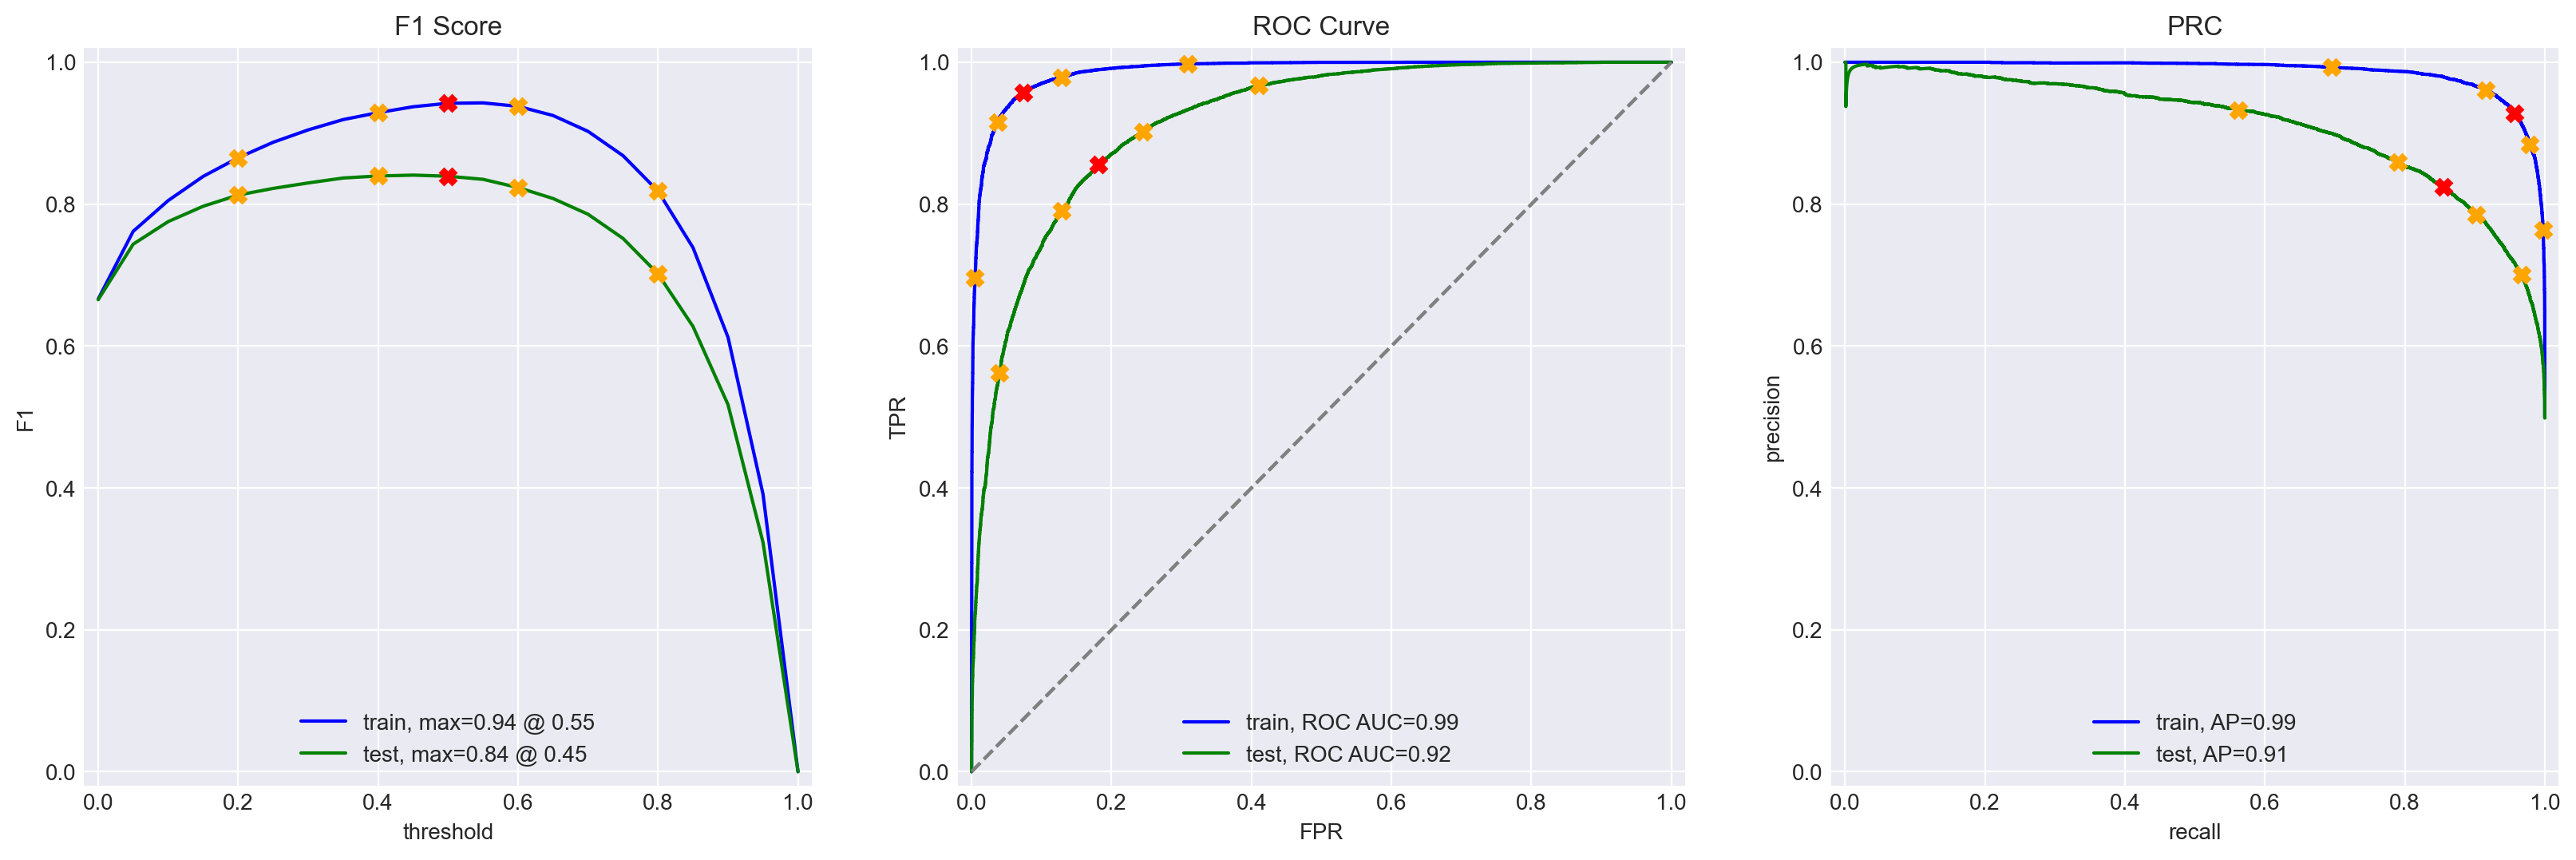

In [24]:
model_2 = xgb.XGBClassifier(random_state=42)
model_2.fit(train_features_1, train_target)
evaluate_model(model_2, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [25]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [27]:
train_features['review_norm'] = train_features['review_norm'].apply(text_preprocessing_3)
test_features['review_norm'] = test_features['review_norm'].apply(text_preprocessing_3)

count_tf_idf_3 = TfidfVectorizer(stop_words='english', max_features=1000)
train_corpus_3 = train_features['review_norm']
train_features_3 = count_tf_idf_3.fit_transform(train_corpus_3)
test_corpus_3 = test_features['review_norm']
test_features_3 = count_tf_idf_3.transform(test_corpus_3)

model_3 = LogisticRegression(random_state=42, max_iter=1000)
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.87  0.85
F1         0.87  0.85
APS        0.94  0.93
ROC AUC    0.94  0.93


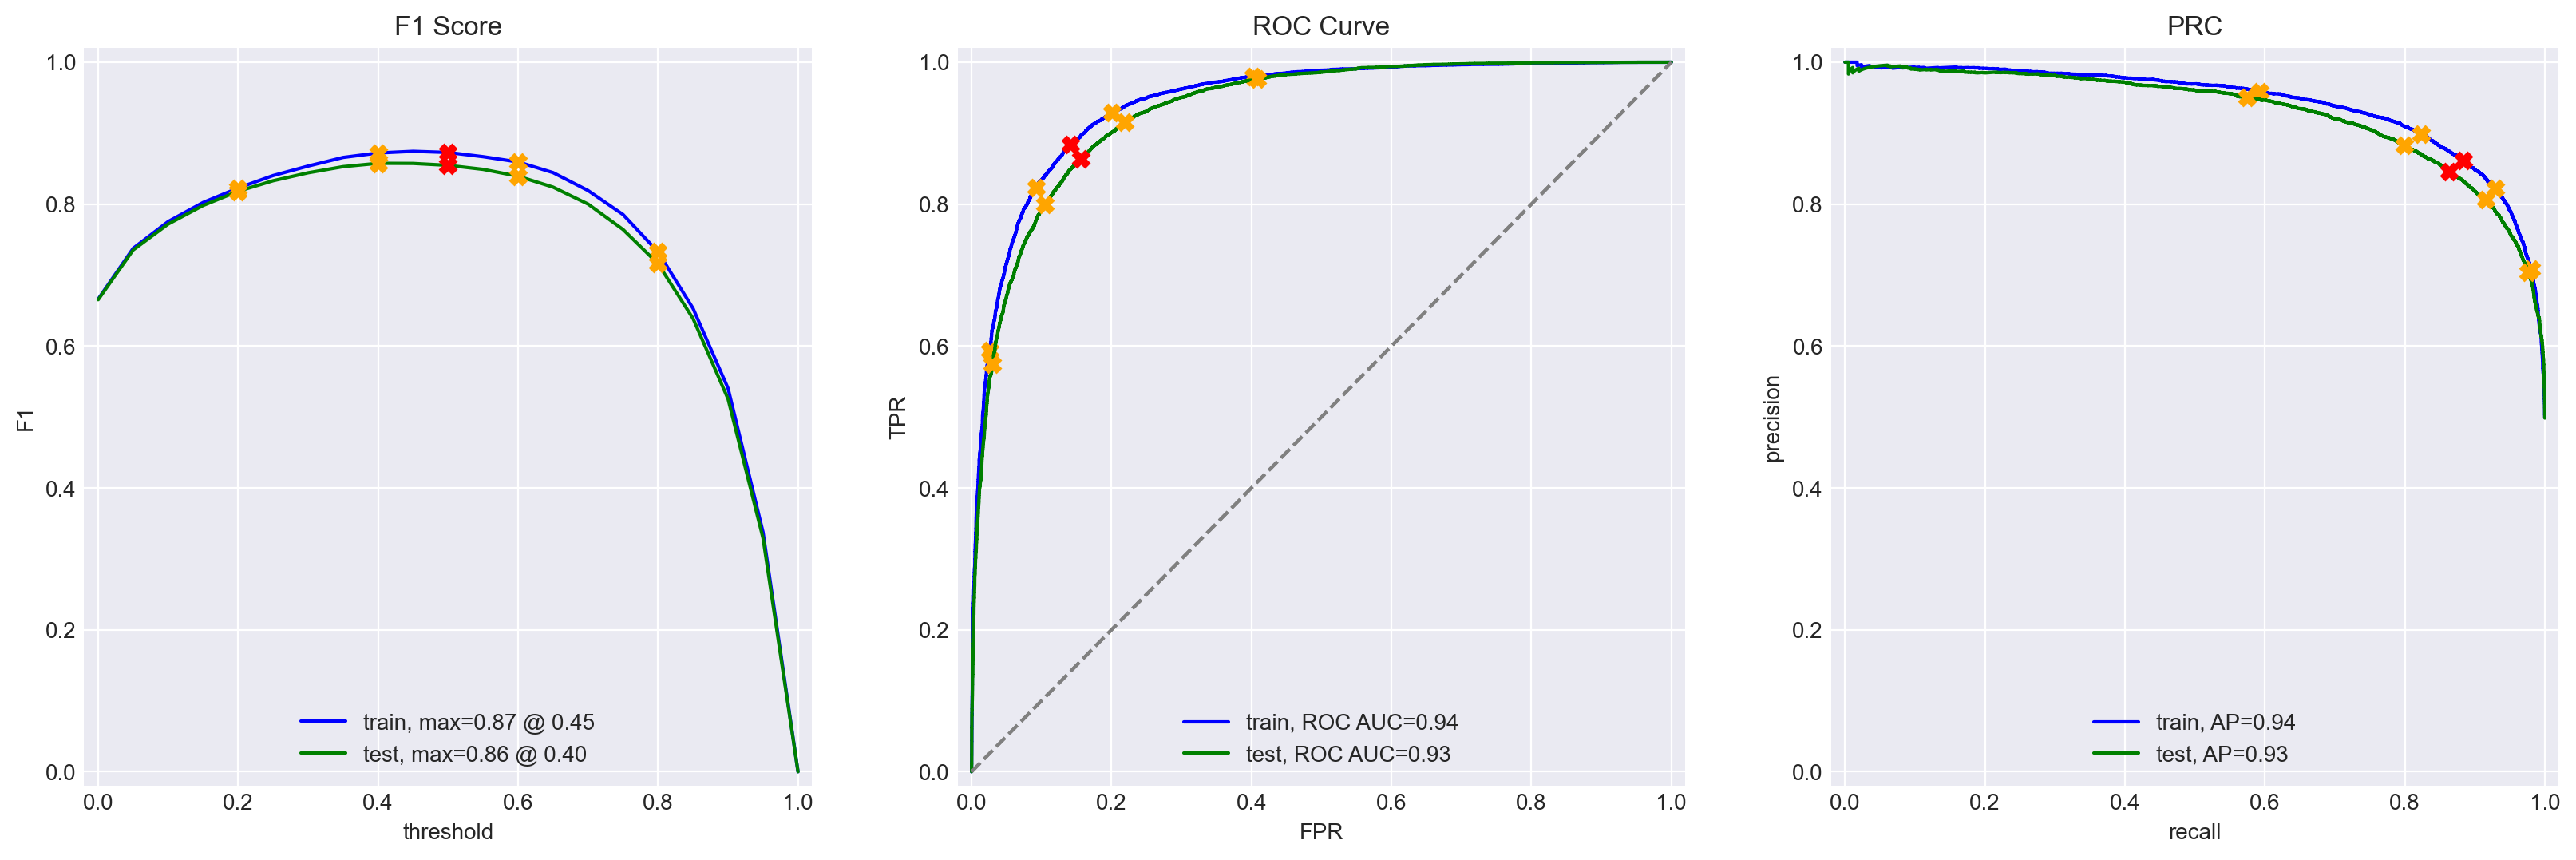

In [28]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [29]:
model_4 = LGBMClassifier(random_state=42)
model_4.fit(train_features_3, train_target)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208830
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


LGBMClassifier(random_state=42)

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/python311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/python311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/python311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy   0.90  0.84
F1         0.90  0.84
APS        0.96  0.92
ROC AUC    0.97  0.92


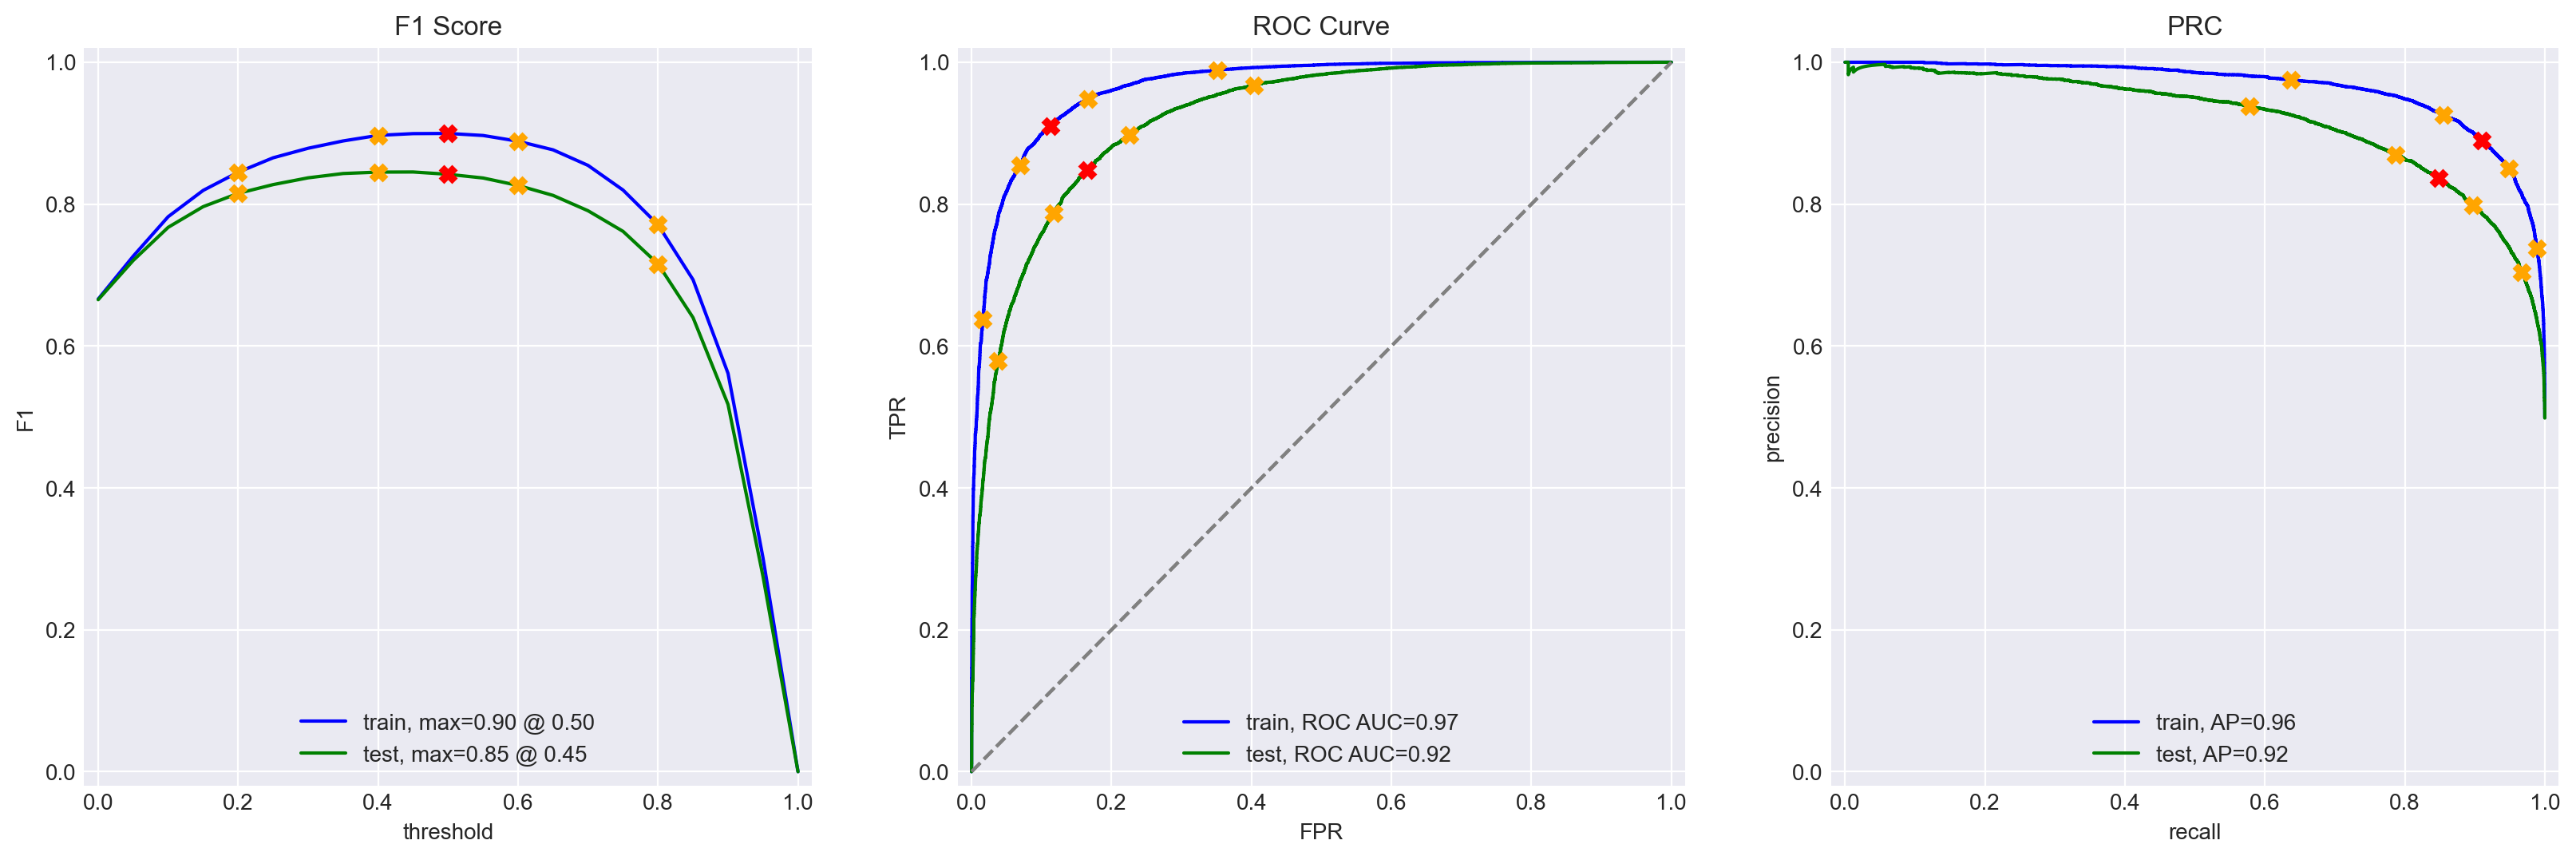

In [30]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

### Model 5 - spaCy, TF-IDF and XGBClassifier

          train  test
Accuracy   0.94  0.84
F1         0.94  0.84
APS        0.99  0.91
ROC AUC    0.99  0.92


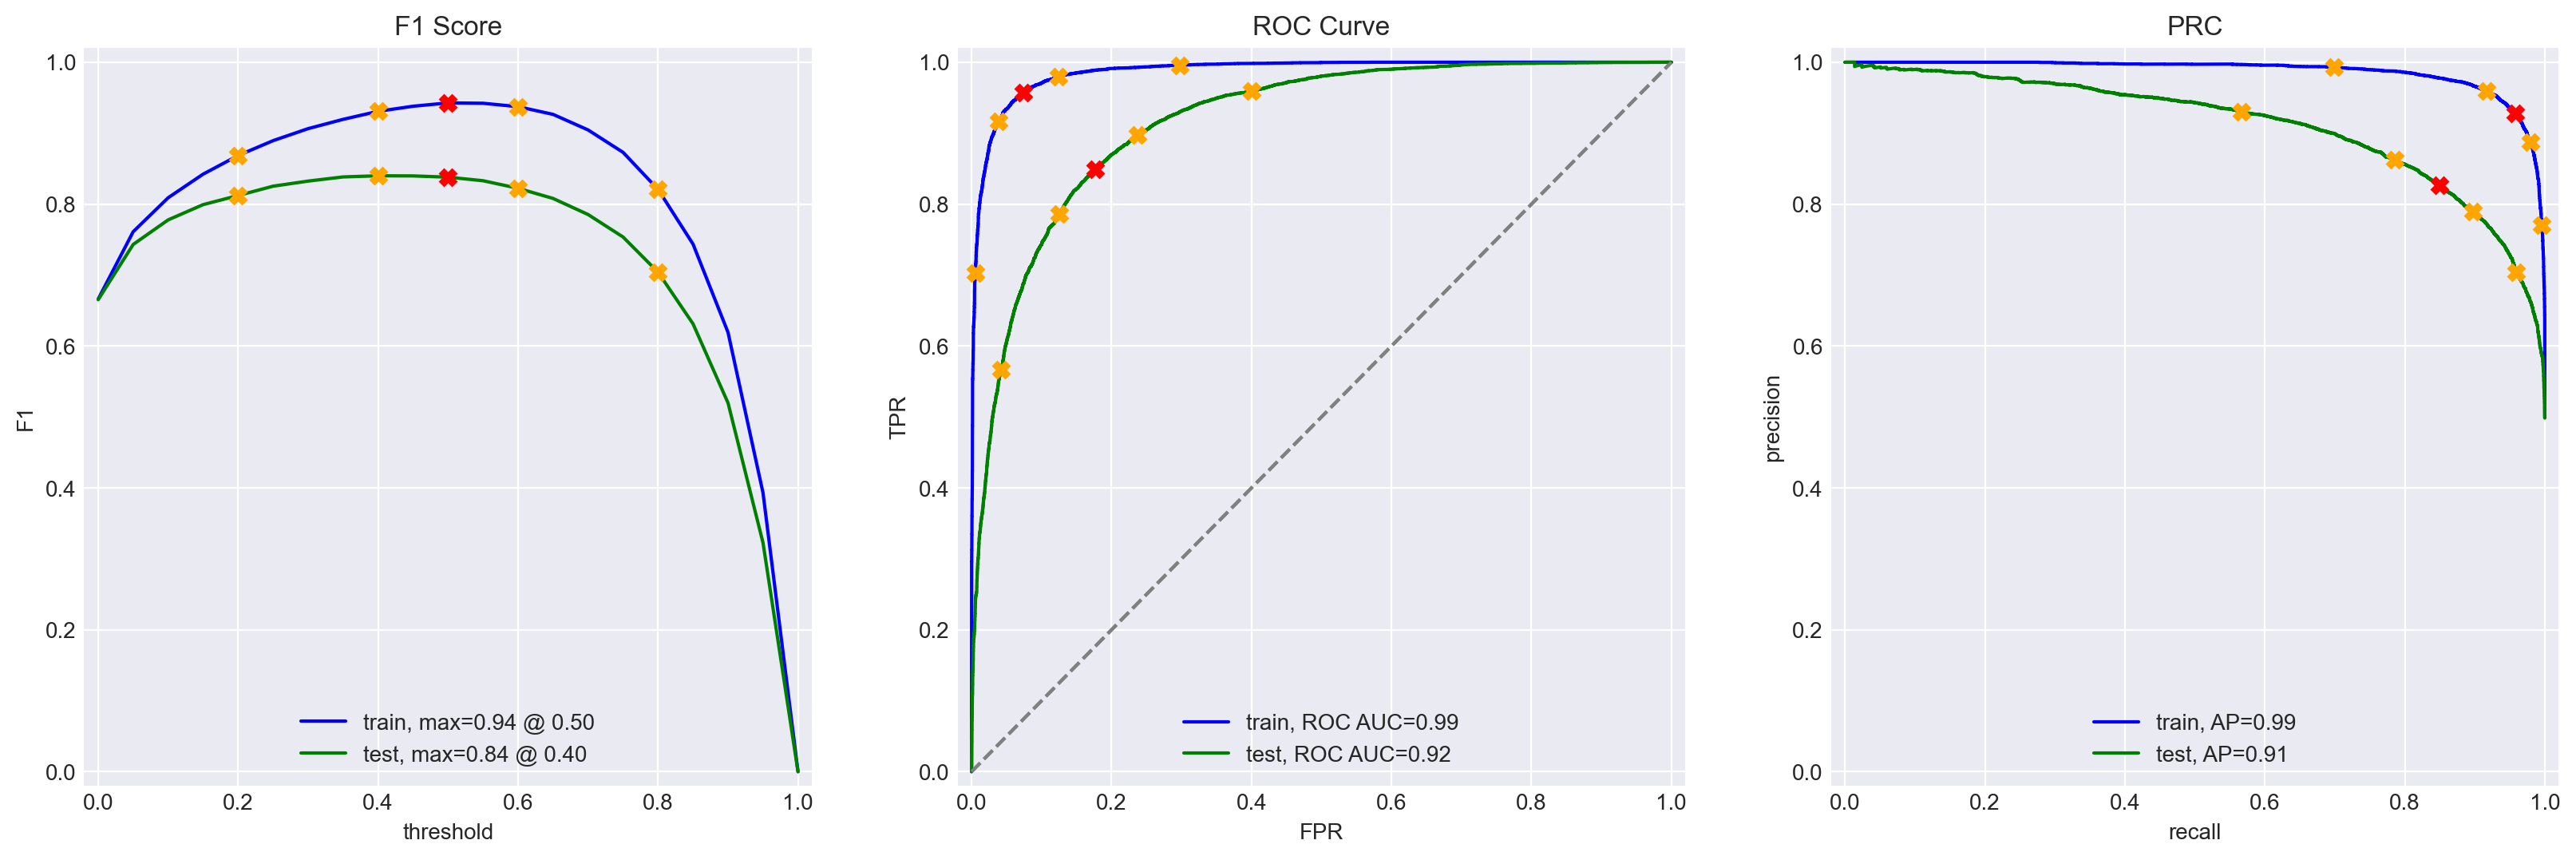

In [31]:
model_5 = xgb.XGBClassifier(random_state=42)
model_5.fit(train_features_3, train_target)
evaluate_model(model_5, train_features_3, train_target, test_features_3, test_target)

###  Model 6 - BERT

In [32]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [33]:
# Use the MPS device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [34]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        ids_list.append(encoded['input_ids'].squeeze().tolist())
        attention_mask_list.append(encoded['attention_mask'].squeeze().tolist())

    # text to padded ids of tokens along with their attention masks
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('mps' if torch.mps.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    if not embeddings:
        raise ValueError('No embeddings were created.')
    return np.concatenate(embeddings)

In [35]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_6 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='mps')

Using the mps device.


100%|██████████| 238/238 [12:20<00:00,  3.11s/it]


In [36]:
print(df_reviews_train['review_norm'].shape)
print(train_features_6.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


In [37]:
test_features_6 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='mps')

Using the mps device.


100%|██████████| 236/236 [12:34<00:00,  3.20s/it]


In [38]:
print(df_reviews_test['review_norm'].shape)
print(test_features_6.shape)
print(test_target.shape)

(23533,)
(23533, 768)
(23533,)


In [39]:
np.savez_compressed('features_6.npz', train_features_6=train_features_6, test_features_6=test_features_6)

with np.load('features_6.npz') as data:
    train_features_9 = data['train_features_6']
    test_features_9 = data['test_features_6']

In [40]:
model_6 = LogisticRegression(random_state=42, max_iter=1000)
model_6.fit(train_features_6, train_target)

LogisticRegression(max_iter=1000, random_state=42)

## My Reviews

In [41]:
my_reviews = pd.DataFrame([
    "Absolutely loved it! The storyline was gripping and the characters were so well-developed.",
"A visual masterpiece! The cinematography was stunning and the soundtrack was perfect.",
"This movie exceeded all my expectations. The plot twists kept me on the edge of my seat.",
"A heartwarming tale that left me in tears. Truly a must-watch for everyone.",
"The director did an amazing job. Every scene was meticulously crafted and the acting was top-notch.",
"I couldn't get into it at all. The pacing was too slow and the plot was confusing.",
"What a disappointment. The trailer promised so much, but the movie failed to deliver.",
"The acting was wooden and the dialogue was cringe-worthy. Not worth my time.",
"I expected a lot more from this film. It felt like a cheap knock-off of better movies.",
"A total waste of time. The plot was nonsensical and the characters were unlikable."
], columns=['review'])

my_reviews['ground_truth'] = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
my_reviews['review_norm'] = my_reviews['review'].apply(normalize)

my_reviews

,review,ground_truth,review_norm
0,Absolutely loved it! The storyline was grippin...,1,absolutely loved it the storyline was gripping...
1,A visual masterpiece! The cinematography was s...,1,a visual masterpiece the cinematography was st...
2,This movie exceeded all my expectations. The p...,1,this movie exceeded all my expectations the pl...
3,A heartwarming tale that left me in tears. Tru...,1,a heartwarming tale that left me in tears trul...
4,The director did an amazing job. Every scene w...,1,the director did an amazing job every scene wa...
5,I couldn't get into it at all. The pacing was ...,0,i couldn t get into it at all the pacing was t...
6,What a disappointment. The trailer promised so...,0,what a disappointment the trailer promised so ...
7,The acting was wooden and the dialogue was cri...,0,the acting was wooden and the dialogue was cri...
8,I expected a lot more from this film. It felt ...,0,i expected a lot more from this film it felt l...
9,A total waste of time. The plot was nonsensica...,0,a total waste of time the plot was nonsensical...


### Model 1 - NLTK, TF-IDF and LR

In [42]:
train_corpus_1.shape

(23796,)

In [43]:
texts = my_reviews['review_norm']
count_tf_idf_1.fit(train_corpus_1)
my_reviews_pred_prob = model_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

pred = []
for i, review in enumerate(texts.str.slice(0,100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f} -- {review}")
print("The f1 score of my reviews dataset is ", f1_score(my_reviews['ground_truth'], pred))

1 -- 0.64 -- absolutely loved it the storyline was gripping and the characters were so well developed
1 -- 0.98 -- a visual masterpiece the cinematography was stunning and the soundtrack was perfect
1 -- 0.28 -- this movie exceeded all my expectations the plot twists kept me on the edge of my seat
1 -- 0.70 -- a heartwarming tale that left me in tears truly a must watch for everyone
1 -- 0.88 -- the director did an amazing job every scene was meticulously crafted and the acting was top notch
0 -- 0.04 -- i couldn t get into it at all the pacing was too slow and the plot was confusing
0 -- 0.08 -- what a disappointment the trailer promised so much but the movie failed to deliver
0 -- 0.55 -- the acting was wooden and the dialogue was cringe worthy not worth my time
0 -- 0.17 -- i expected a lot more from this film it felt like a cheap knock off of better movies
0 -- 0.01 -- a total waste of time the plot was nonsensical and the characters were unlikable
The f1 score of my reviews datase

### Model 2 - NLTK, TF-IDF and XGBoost

In [44]:
my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

pred = []
for i, review in enumerate(texts.str.slice(0, 100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f}:  {review}")
print("The f1 score of my reviews dataset is ", f1_score(my_reviews['ground_truth'], pred))

1 -- 0.76:  absolutely loved it the storyline was gripping and the characters were so well developed
1 -- 0.92:  a visual masterpiece the cinematography was stunning and the soundtrack was perfect
1 -- 0.53:  this movie exceeded all my expectations the plot twists kept me on the edge of my seat
1 -- 0.66:  a heartwarming tale that left me in tears truly a must watch for everyone
1 -- 0.82:  the director did an amazing job every scene was meticulously crafted and the acting was top notch
0 -- 0.47:  i couldn t get into it at all the pacing was too slow and the plot was confusing
0 -- 0.37:  what a disappointment the trailer promised so much but the movie failed to deliver
0 -- 0.62:  the acting was wooden and the dialogue was cringe worthy not worth my time
0 -- 0.50:  i expected a lot more from this film it felt like a cheap knock off of better movies
0 -- 0.08:  a total waste of time the plot was nonsensical and the characters were unlikable
The f1 score of my reviews dataset is  0.83

### Model 3 - spaCy, TF-IDF and LR

In [45]:
texts = my_reviews['review_norm']
count_tf_idf_3.fit(train_corpus_3)
my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
pred = []
for i, review in enumerate(texts.str.slice(0, 100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f}:  {review}")
print("The f1 score of my reviews dataset is ", f1_score(my_reviews['ground_truth'], pred))

1 -- 0.54:  absolutely loved it the storyline was gripping and the characters were so well developed
1 -- 0.98:  a visual masterpiece the cinematography was stunning and the soundtrack was perfect
1 -- 0.72:  this movie exceeded all my expectations the plot twists kept me on the edge of my seat
1 -- 0.87:  a heartwarming tale that left me in tears truly a must watch for everyone
1 -- 0.89:  the director did an amazing job every scene was meticulously crafted and the acting was top notch
0 -- 0.05:  i couldn t get into it at all the pacing was too slow and the plot was confusing
0 -- 0.07:  what a disappointment the trailer promised so much but the movie failed to deliver
0 -- 0.59:  the acting was wooden and the dialogue was cringe worthy not worth my time
0 -- 0.33:  i expected a lot more from this film it felt like a cheap knock off of better movies
0 -- 0.01:  a total waste of time the plot was nonsensical and the characters were unlikable
The f1 score of my reviews dataset is  0.90

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [46]:
texts = my_reviews['review_norm']
pred = []

my_reviews_pred_prob = model_4.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f}:  {review}")
print("The f1 score of my reviews dataset is ", f1_score(my_reviews['ground_truth'], pred))

1 -- 0.87:  absolutely loved it the storyline was gripping and the characters were so well developed
1 -- 0.94:  a visual masterpiece the cinematography was stunning and the soundtrack was perfect
1 -- 0.60:  this movie exceeded all my expectations the plot twists kept me on the edge of my seat
1 -- 0.80:  a heartwarming tale that left me in tears truly a must watch for everyone
1 -- 0.79:  the director did an amazing job every scene was meticulously crafted and the acting was top notch
0 -- 0.36:  i couldn t get into it at all the pacing was too slow and the plot was confusing
0 -- 0.22:  what a disappointment the trailer promised so much but the movie failed to deliver
0 -- 0.69:  the acting was wooden and the dialogue was cringe worthy not worth my time
0 -- 0.48:  i expected a lot more from this film it felt like a cheap knock off of better movies
0 -- 0.08:  a total waste of time the plot was nonsensical and the characters were unlikable
The f1 score of my reviews dataset is  0.90

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Model 5 - spaCy, TF-IDF and XGBClassifier

In [47]:
texts = my_reviews['review_norm']
count_tf_idf_3.fit(train_corpus_3)
my_reviews_pred_prob = model_5.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
pred = []
for i, review in enumerate(texts.str.slice(0, 100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f}:  {review}")
print("The f1 score of my reviews dataset is ", f1_score(my_reviews['ground_truth'], pred))

1 -- 0.87:  absolutely loved it the storyline was gripping and the characters were so well developed
1 -- 0.94:  a visual masterpiece the cinematography was stunning and the soundtrack was perfect
1 -- 0.60:  this movie exceeded all my expectations the plot twists kept me on the edge of my seat
1 -- 0.78:  a heartwarming tale that left me in tears truly a must watch for everyone
1 -- 0.83:  the director did an amazing job every scene was meticulously crafted and the acting was top notch
0 -- 0.46:  i couldn t get into it at all the pacing was too slow and the plot was confusing
0 -- 0.29:  what a disappointment the trailer promised so much but the movie failed to deliver
0 -- 0.66:  the acting was wooden and the dialogue was cringe worthy not worth my time
0 -- 0.49:  i expected a lot more from this film it felt like a cheap knock off of better movies
0 -- 0.09:  a total waste of time the plot was nonsensical and the characters were unlikable
The f1 score of my reviews dataset is  0.90

### Model 6 - BERT

In [48]:
texts = my_reviews['review_norm']

my_reviews_features_6 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_6.predict_proba(my_reviews_features_6)[:, 1]

pred = []

for i, review in enumerate(texts.str.slice(0, 100)):
    if my_reviews_pred_prob[i] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
    print(f"{my_reviews['ground_truth'][i]} -- {my_reviews_pred_prob[i]:.2f}:  {review}")
f1 = f1_score(my_reviews['ground_truth'], pred)
print("The f1 score of my reviews dataset is ", f1)

1 -- 1.00:  absolutely loved it the storyline was gripping and the characters were so well developed
1 -- 1.00:  a visual masterpiece the cinematography was stunning and the soundtrack was perfect
1 -- 0.57:  this movie exceeded all my expectations the plot twists kept me on the edge of my seat
1 -- 1.00:  a heartwarming tale that left me in tears truly a must watch for everyone
1 -- 0.98:  the director did an amazing job every scene was meticulously crafted and the acting was top notch
0 -- 0.05:  i couldn t get into it at all the pacing was too slow and the plot was confusing
0 -- 0.00:  what a disappointment the trailer promised so much but the movie failed to deliver
0 -- 0.00:  the acting was wooden and the dialogue was cringe worthy not worth my time
0 -- 0.11:  i expected a lot more from this film it felt like a cheap knock off of better movies
0 -- 0.01:  a total waste of time the plot was nonsensical and the characters were unlikable
The f1 score of my reviews dataset is  1.0


## Conclusions

I have applied 3 machine learning models (XGBoost, LightGBM & Linear Regression) on 2 types of datasets (NLTK/TF-IDF & spaCy/TF-IDF) and then I also scored using the BERT method. All of them perform well on the test set.

| Model | Score |
| ---   | ---   |
| NLTK/TF-IDF - Linear Regression | 80% |
| NLTK/TF-IDF - XGBoost | 83% |
| spaCy/TF-IDF - Linear Regression | 91% |
| spaCy/TF-IDF - LightGBM | 91% |
| spaCy/TF-IDF - XGBoost | 91% |
| BERT | 100% |

The models got increasingly better. The NLTK with Linear Regression model performed well at 80% but then the NLTK with XGBoost performed a tad better at 83%.

The spaCy with Linear Regression scored a 91%, the spaCy with LightGBM scored a 91% and the spaCy with XGBoost scored a 91%.

And the BERT model scored a perfect 100% on the test reviews.

This shows that if we're only considering to analyze the sentiment of sentences, most regular machine learning models will obtain a good enough result once the corpus is vectorized proeperly.